In [1]:
import warnings
for warn in [UserWarning, FutureWarning]: warnings.filterwarnings("ignore", category = warn)

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import hub
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchaudio

import numpy as np
import pandas as pd

from sklearn.metrics import f1_score, recall_score, precision_score, balanced_accuracy_score, accuracy_score, classification_report
from sklearn.utils import shuffle

import scipy

from tqdm import tqdm

from datasets import load_dataset, Dataset, Audio
import librosa
from transformers import AutoFeatureExtractor, Wav2Vec2ForSequenceClassification

# from models.swishnet import SwishNet

from src.utils import AphasiaDatasetMFCC, AphasiaDatasetSpectrogram, AphasiaDatasetWaveform

from collections import Counter

from torch_audiomentations import Compose, AddColoredNoise, PitchShift, Gain

2025-03-16 22:20:33.038984: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-16 22:20:33.323406: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742152833.421637  436073 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742152833.454684  436073 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-16 22:20:33.704924: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
augmentations = Compose(
    transforms=[
        Gain(
            min_gain_in_db=-15.0,
            max_gain_in_db=5.0,
            sample_rate=8_000,
            p=0.5,
        ),
        AddColoredNoise(sample_rate=8_000, p=0.75),
        PitchShift(sample_rate=8_000, p=0.75),
    ]
)

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
AUDIO_LENGTH = 6_000
SEQUENCE_LENGTH = 420
MFCC = 128
print(f"It's {DEVICE} time!!!")

It's cuda time!!!


In [4]:
DATA_DIR = os.path.join('..', 'data')
VOICES_DIR = os.path.join(DATA_DIR, 'Voices')
APHASIA_DIR = os.path.join(VOICES_DIR, 'Aphasia')
NORM_DIR = os.path.join(VOICES_DIR, 'Norm')

In [5]:
train_dataset = AphasiaDatasetMFCC(os.path.join(DATA_DIR, "train_filenames.csv"), VOICES_DIR, target_sample_rate=8_000, mfcc=MFCC, n_mels=128, fft_size=512,
                 hop_length=256, win_length=512, min_duration=10, max_duration=15, )
test_dataset = AphasiaDatasetMFCC(os.path.join(DATA_DIR, "val_filenames.csv"), VOICES_DIR, target_sample_rate=8_000, mfcc=MFCC, n_mels=128, fft_size=512,
                 hop_length=256, win_length=512, min_duration=10, max_duration=15)
val_dataset = AphasiaDatasetMFCC(os.path.join(DATA_DIR, "test_filenames.csv"), VOICES_DIR, target_sample_rate=8_000, mfcc=MFCC, n_mels=128, fft_size=512,
                 hop_length=256, win_length=512, min_duration=10, max_duration=15)

# Балансировка классов для train
train_labels = [label for _, label in train_dataset.data]
class_counts = Counter(train_labels)
if len(class_counts) < 2:
    raise ValueError("Один из классов отсутствует в тренировочном наборе")

class_weights = {label: 1.0 / count for label, count in class_counts.items()}
weights = [class_weights[label] for _, label in train_dataset.data]
train_sampler = WeightedRandomSampler(weights, num_samples=len(train_dataset), replacement=True)


In [6]:
def pad_sequence(batch):
    if not batch:
        return torch.zeros(0), torch.zeros(0)
    
    seq, labels = zip(*batch)
    # print(seq[1], labels)
    max_len = max(s.shape[1] for s in seq)
    # print(max_len)

    # print(seq[0].shape)
    padded = torch.zeros(len(seq), MFCC, SEQUENCE_LENGTH)
    for i, s in enumerate(seq):
        # print(s.shape)
        padded[i, ..., :s.shape[-1]] = s[..., :SEQUENCE_LENGTH]
    
    return padded, torch.stack(labels) 

In [7]:
train_dataloader = DataLoader(train_dataset, batch_size=64, sampler=train_sampler, collate_fn=pad_sequence, drop_last=True, num_workers=6)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=pad_sequence, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=pad_sequence, drop_last=True, num_workers=6)

In [8]:
t = next(iter(train_dataloader))

In [9]:
t[0].shape

torch.Size([64, 128, 420])

In [10]:
def train_model(model, dl_train, dl_val, epochs=1, lr=0.001, device="cpu"):
      
    model = model.to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
        
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3, threshold=1e-3)
    # scheduler = step_scheduler(optimizer, 30) 
        
    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []
    for epoch in tqdm(range(epochs), desc="Training model"):
        model.train()
        total_train_loss = 0
        total_val_loss = 0
        
        train_acc = []
        val_acc = []
        for features, target in dl_train:
            features, target = features.to(device), target.to(device)
            optimizer.zero_grad()
            
            output = model(features).squeeze()
            # print(output.shape)
            # train_acc.append(torch.tensor(torch.argmax(output, dim=1) == target).cpu().detach().numpy())
            preds = torch.argmax(output, dim=1).cpu().detach().numpy()
            train_acc.append(accuracy_score(target.cpu().detach().numpy(), preds))
            
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.detach().item()
        # print(f"LR before: {optimizer.param_groups[0]['lr']}")
        # scheduler.step(epoch=epoch)
        # print(f"LR after: {optimizer.param_groups[0]['lr']}")
        
        avg_train_acc = np.stack(train_acc, axis=0).mean()

        avg_train_loss = total_train_loss / len(train_dataloader)
        train_loss_list.append(avg_train_loss)
        train_acc_list.append(avg_train_acc)
                
        model.eval()
        
        with torch.no_grad():
            for features, target in dl_val:
                features, target = features.to(device), target.to(device)
                
                output = model(features).squeeze()
                
                preds = torch.argmax(output, dim=1).cpu().detach().numpy()
                val_acc.append(accuracy_score(target.cpu().detach().numpy(), preds))
                loss = criterion(output, target)
                total_val_loss += loss.detach().item()
        
        avg_val_acc = np.stack(val_acc, axis=0).mean()
        avg_val_loss = total_val_loss / len(dl_val)
        val_loss_list.append(avg_val_loss)
        val_acc_list.append(avg_val_acc)
        
        if scheduler:
            try:
                scheduler.step()
            except:
                scheduler.step(avg_val_loss)
        
        # if epoch % 10 == 0:
        tqdm.write(f"Epoch {epoch}: train loss: {avg_train_loss:.3f}, train balanced acc: {avg_train_acc:.2f}, test loss: {avg_val_loss:.3f}, test balanced acc: {avg_val_acc:.2f}, lr: {optimizer.param_groups[0]['lr']}")

            
    return model, train_loss_list, val_loss_list, train_acc_list, val_acc_list

In [11]:
import torch
from torch import nn
import math


class MaskedConv1d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1, mask=None, input_size=42):
        super(MaskedConv1d, self).__init__()

        # padding = max(0, (math.ceil((stride - 1) * in_channels + (kernel_size - 1) * dilation + 1 - stride) / stride - input_size))
        # padding = (stride * (input_size - 1) + kernel_size - input_size) // 2
        # padding = stride * (kernel_size - 1) * dilation // 2
        # if kernel_size % 2 == 0:
        #     padding -= 1
        # padding = ((kernel_size - 1) * dilation - stride + 1)// 2
        padding = math.ceil(((input_size - 1) * stride + 1 + dilation * (kernel_size - 1) - input_size) / 2)

        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, dilation=dilation, padding=padding)

        # if mask is None:
        #     self.mask = torch.ones(kernel_size)
        # else:
        #     self.mask = mask.detach().clone()
        # 
        # self.mask = nn.Parameter(self.mask, requires_grad=False)
        # 
        # with torch.no_grad():
        #     self.conv.weight = torch.nn.Parameter(self.mask * self.conv.weight)
        # 
        # self.conv.weight.register_hook(lambda x: x * self.mask)

    def forward(self, x):

        return self.conv(x)


class GatedActivation(nn.Module):

    def __init__(self):
        super(GatedActivation, self).__init__()

        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self, x):
        x_sigmoid = self.sigmoid(x)
        x_tanh = self.tanh(x)
        return x_sigmoid * x_tanh * x   # x * ???


class GatedConv1d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1, mask=None, input_size=42):
        super(GatedConv1d, self).__init__()

        self.conv = MaskedConv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, mask=mask,
                                 stride=stride, dilation=dilation, input_size=input_size)

        self.gate = GatedActivation()

    def forward(self, x):
        x = self.conv(x)
        x = self.gate(x)
        return x


class SwishNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=2, input_size=42, dropout_rate=0.1):
        super(SwishNet, self).__init__()

        kernel_size_3 = 3
        mask_3 = torch.ones(kernel_size_3)
        mask_3[kernel_size_3 // 2 + 1:] -= 1

        kernel_size_6 = 5
        mask_6 = torch.ones(kernel_size_6)
        mask_6[kernel_size_6 // 2:] -= 1

        self.gatedconv1_1 = GatedConv1d(in_channels=in_channels, out_channels=16, kernel_size=kernel_size_3, mask=mask_3, input_size=input_size)
        self.gatedconv1_2 = GatedConv1d(in_channels=in_channels, out_channels=16, kernel_size=kernel_size_6, mask=mask_6, input_size=input_size)
        
        self.dropout1 = nn.Dropout(dropout_rate)

        self.batchnorm1 = nn.BatchNorm1d(32)
        self.gatedconv2_1 = GatedConv1d(in_channels=32, out_channels=8, kernel_size=kernel_size_3, mask=mask_3, input_size=input_size)
        self.gatedconv2_2 = GatedConv1d(in_channels=32, out_channels=8, kernel_size=kernel_size_6, mask=mask_6, input_size=input_size)

        self.dropout2 = nn.Dropout(dropout_rate)

        self.batchnorm2 = nn.BatchNorm1d(16)
        self.gatedconv3_1 = GatedConv1d(in_channels=16, out_channels=8, kernel_size=kernel_size_3, mask=mask_3, input_size=input_size)
        self.gatedconv3_2 = GatedConv1d(in_channels=16, out_channels=8, kernel_size=kernel_size_6, mask=mask_6, input_size=input_size)

        self.dropout3 = nn.Dropout(dropout_rate)

        self.batchnorm3 = nn.BatchNorm1d(16)
        self.gatedconv4 = GatedConv1d(in_channels=16, out_channels=16, kernel_size=kernel_size_3, mask=mask_3, stride=3, input_size=input_size)
        
        self.dropout4 = nn.Dropout(dropout_rate)

        self.batchnorm4 = nn.BatchNorm1d(16)
        self.gatedconv5 = GatedConv1d(in_channels=16, out_channels=16, kernel_size=kernel_size_3, mask=mask_3, stride=2, input_size=input_size)

        self.batchnorm5 = nn.BatchNorm1d(16)
        self.dropout5 = nn.Dropout(dropout_rate)
        self.gatedconv6 = GatedConv1d(in_channels=16, out_channels=16, kernel_size=kernel_size_3, mask=mask_3, stride=2, input_size=input_size)

        self.dropout6 = nn.Dropout(dropout_rate)

        self.batchnorm6 = nn.BatchNorm1d(16)
        self.gatedconv7 = GatedConv1d(in_channels=16, out_channels=16, kernel_size=kernel_size_3, mask=mask_3, stride=2, input_size=input_size) # 2

        self.batchnorm7 = nn.BatchNorm1d(16)
        self.dropout7 = nn.Dropout(dropout_rate)
        self.gateconv8 = GatedConv1d(in_channels=16, out_channels=32, kernel_size=kernel_size_3, mask=mask_3, stride=1, input_size=input_size) # 2

        # self.gateconv9 = GatedConv1d(in_channels=80, out_channels=out_channels, kernel_size=1, input_size=input_size)

        self.batchnorm8 = nn.BatchNorm1d(32)
        self.conv9 = nn.Conv1d(in_channels=80, out_channels=out_channels, kernel_size=1,)

        self.global_pool = nn.AdaptiveAvgPool1d(1)

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x1_1 = self.gatedconv1_1(x)
        x1_2 = self.gatedconv1_2(x)

        x1 = torch.cat([x1_1, x1_2], dim=1)

        x1 = self.batchnorm1(x1)

        x2_1 = self.gatedconv2_1(x1)
        x2_2 = self.gatedconv2_2(x1)
        x2 = torch.cat([x2_1, x2_2], dim=1)

        x2 = self.batchnorm2(x2)

        x3_1 = self.gatedconv3_1(x2)
        x3_2 = self.gatedconv3_2(x2)
        x3 = torch.cat([x3_1, x3_2], dim=1) + x2

        x3 = self.batchnorm3(x3)
        x3 = self.dropout3(x3)

        x4 = self.gatedconv4(x3) # + x3

        x4 += x3

        x4 = self.batchnorm4(x4)

        x5_cat = self.gatedconv5(x4)

        x5 = x5_cat + x4

        x5 = self.batchnorm5(x5)

        x6_cat = self.gatedconv6(x5)
        x6 = x6_cat + x5

        x6 = self.batchnorm6(x6)
        x6 = self.dropout6(x6)

        x7_cat = self.gatedconv7(x6)

        x7_cat = self.batchnorm7(x7_cat)

        x8_cat = self.gateconv8(x7_cat)

        x8_cat = self.batchnorm8(x8_cat)

        x_cat = torch.cat([x5_cat, x6_cat, x7_cat, x8_cat], dim=1)

        # x_cat = self.batchnorm8(x_cat)

        x9 = self.conv9(x_cat)

        x10 = self.global_pool(x9)

        return self.softmax(x10)


In [12]:
swishnet = SwishNet(MFCC, 2, input_size=SEQUENCE_LENGTH, dropout_rate=0.5)

In [13]:
swishnet, train_l, val_l, train_accuracy, val_accuracy = train_model(swishnet, train_dataloader, val_dataloader, epochs=6, lr=1e-3, device=DEVICE)

Training model:  17%|█▋        | 1/6 [00:01<00:06,  1.27s/it]

Epoch 0: train loss: 0.597, train balanced acc: 0.80, test loss: 0.521, test balanced acc: 0.89, lr: 0.001


Training model:  33%|███▎      | 2/6 [00:02<00:04,  1.08s/it]

Epoch 1: train loss: 0.472, train balanced acc: 0.89, test loss: 0.492, test balanced acc: 0.82, lr: 0.001


Training model:  50%|█████     | 3/6 [00:03<00:03,  1.05s/it]

Epoch 2: train loss: 0.408, train balanced acc: 0.93, test loss: 0.434, test balanced acc: 0.89, lr: 0.001


Training model:  67%|██████▋   | 4/6 [00:04<00:02,  1.01s/it]

Epoch 3: train loss: 0.372, train balanced acc: 0.96, test loss: 0.493, test balanced acc: 0.81, lr: 0.001


Training model:  83%|████████▎ | 5/6 [00:05<00:00,  1.01it/s]

Epoch 4: train loss: 0.353, train balanced acc: 0.97, test loss: 0.397, test balanced acc: 0.92, lr: 0.001


Training model: 100%|██████████| 6/6 [00:06<00:00,  1.01s/it]

Epoch 5: train loss: 0.343, train balanced acc: 0.98, test loss: 0.453, test balanced acc: 0.85, lr: 0.001


In [37]:
st = torch.load(os.path.join("..", "checkpoints", "swishnet_chkp", "swishnet_0.911_best_.pt"), weights_only=False)   # 6 эпох, а не 10

swishnet = SwishNet(MFCC, 2, input_size=SEQUENCE_LENGTH, dropout_rate=0.5)

swishnet.load_state_dict(st["model_state_dict"])

<All keys matched successfully>

In [38]:
def test_model(model, test_data):
    model = model.to(DEVICE)
        
    model.eval()
    preds = []
    targets = []
    with torch.no_grad():
        for features, target in tqdm(test_data):
            features = features.to(DEVICE)
            target = target.to(DEVICE)
            
            label = model(features).to("cpu").detach().numpy().squeeze()
            preds.extend(label.argmax(axis=-1).tolist())
            # print(target.shape)
            targets.extend(target.to("cpu").tolist())

    preds = np.array(preds)
    # print(targets)
    print(classification_report(targets, preds))    

    return preds

In [39]:
test_model(swishnet, test_dataloader)

100%|██████████| 13/13 [00:00<00:00, 127.44it/s]

              precision    recall  f1-score   support

           0       0.56      0.86      0.68       104
           1       0.98      0.91      0.94       728

    accuracy                           0.90       832
   macro avg       0.77      0.88      0.81       832
weighted avg       0.93      0.90      0.91       832



array([1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,

              precision    recall  f1-score   support

           0       0.86      0.71      0.77       102
           1       0.96      0.98      0.97       730

    accuracy                           0.95       832
   macro avg       0.91      0.84      0.87       832
weighted avg       0.95      0.95      0.95       832

Text(0.5, 0, 'Epoch')

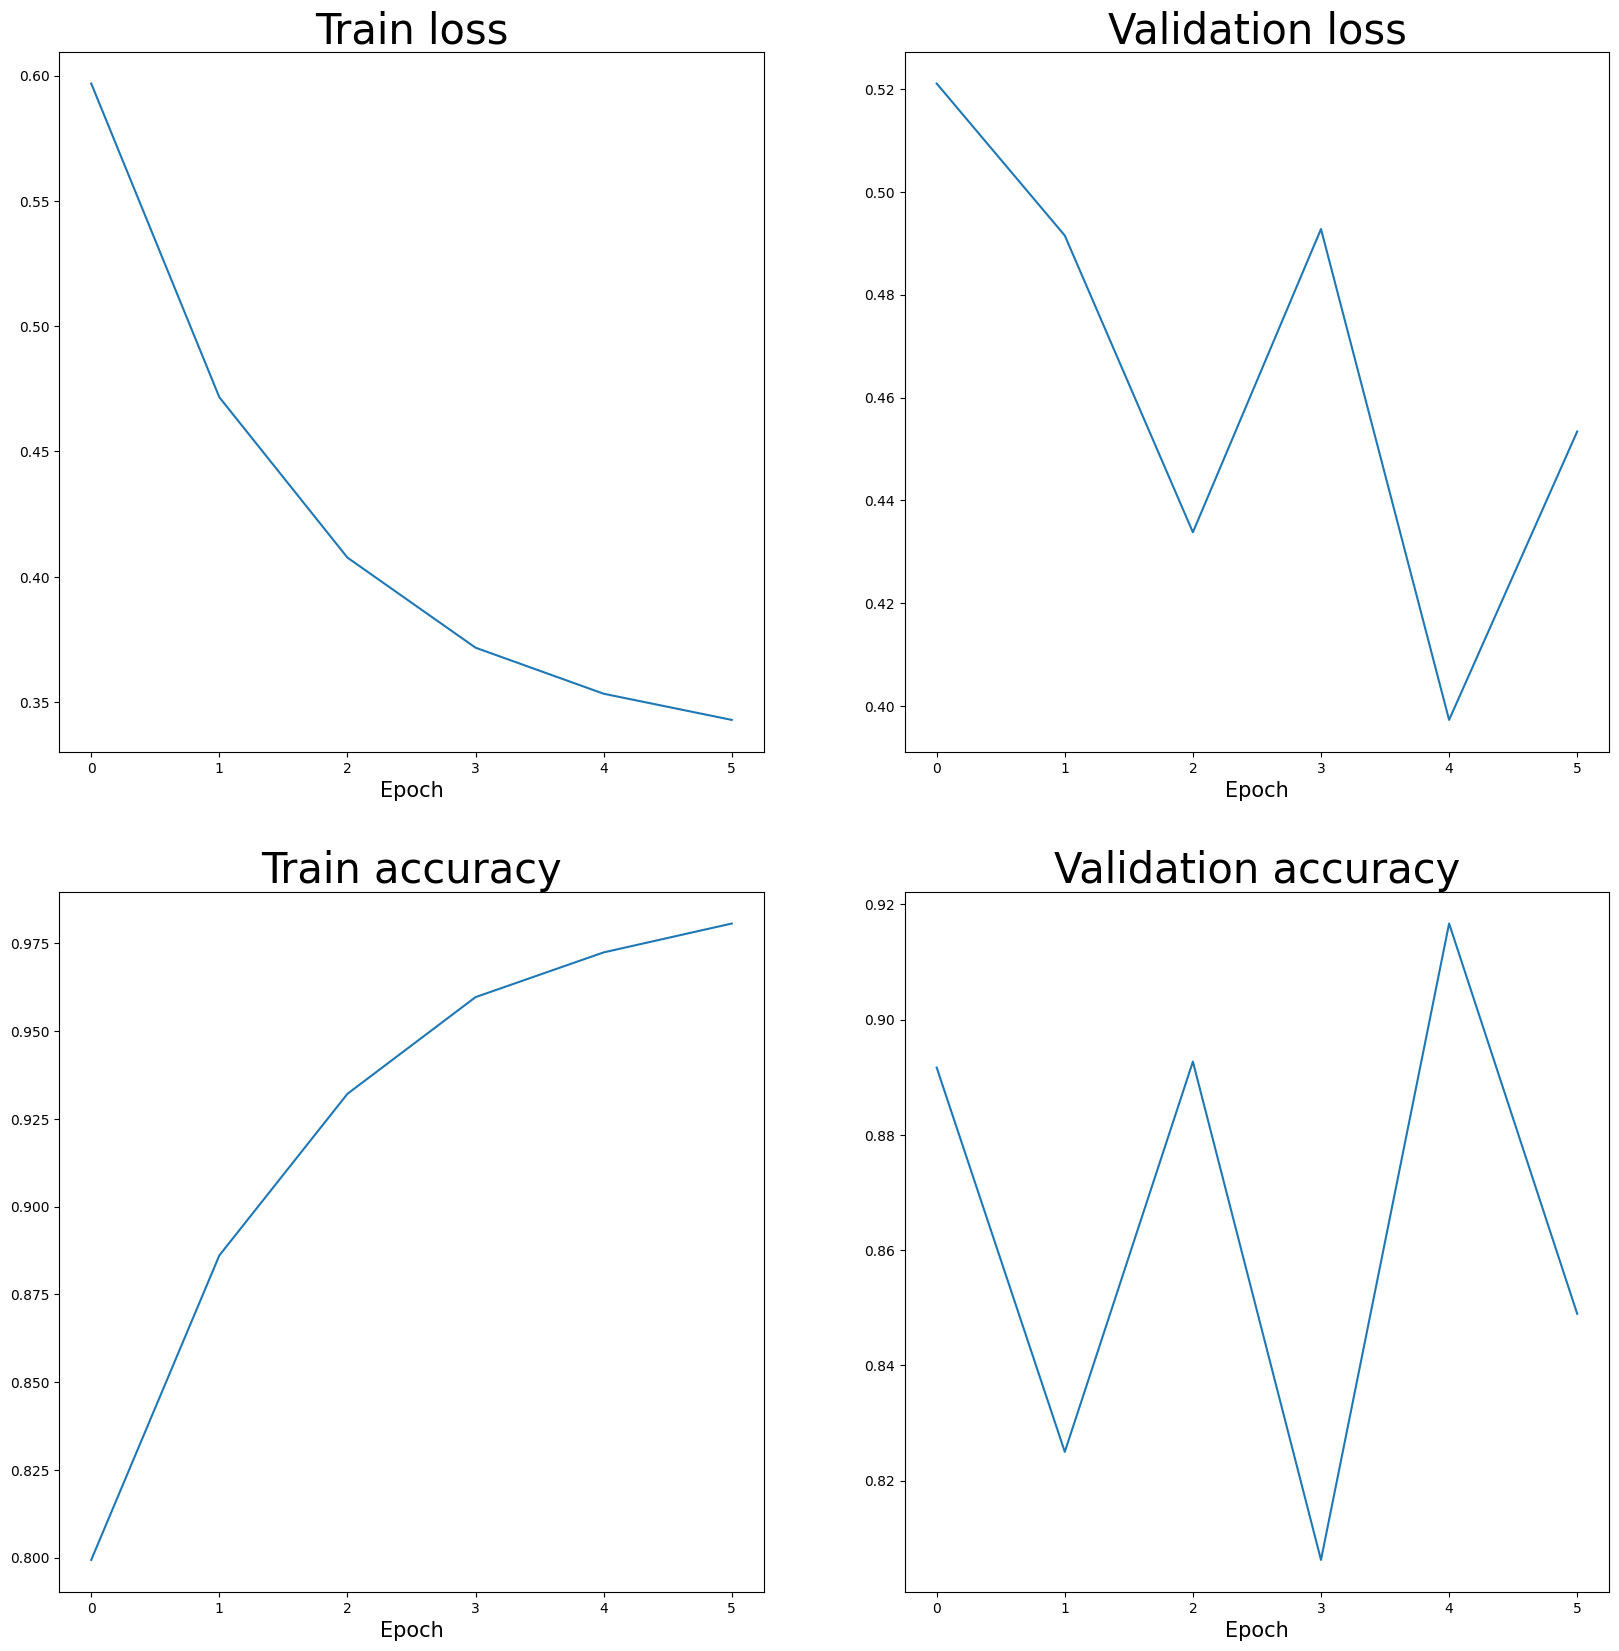

In [40]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

axes[0][0].plot(train_l)
axes[0][0].set_title("Train loss", fontsize=30)
axes[0][0].set_xlabel("Epoch", fontsize=15)

axes[0][1].plot(val_l)
axes[0][1].set_title("Validation loss", fontsize=30)
axes[0][1].set_xlabel("Epoch", fontsize=15)

axes[1][0].plot(train_accuracy)
axes[1][0].set_title("Train accuracy", fontsize=30)
axes[1][0].set_xlabel("Epoch", fontsize=15)

axes[1][1].plot(val_accuracy)
axes[1][1].set_title("Validation accuracy", fontsize=30)
axes[1][1].set_xlabel("Epoch", fontsize=15)

In [41]:
# CHECKPOINTS_DIR = os.path.join("..", "checkpoints")
# 
# if not os.path.exists(os.path.join(CHECKPOINTS_DIR, "swishnet_chkp")):
#     os.makedirs(os.path.join(CHECKPOINTS_DIR, "swishnet_chkp"))
# 
# torch.save(
#     {
#         'epoch': 10,
#         'model_state_dict': swishnet.state_dict(),
#         # 'optimizer_state_dict': optimizer.state_dict(),
#         # 'scheduler_state_dict': scheduler.state_dict(),
#         'losses_train': train_l,
#         'losses_val': val_l,
#     },
#     os.path.join(CHECKPOINTS_DIR, "swishnet_chkp", "swishnet" + "_" + "{:.3f}".format(val_accuracy[-1]) + ".pt"),
# )

In [42]:
test_data = pd.read_csv(os.path.join(DATA_DIR, 'test_filenames.csv'))

In [43]:
DATA_DIR = os.path.join('..', 'data')
VOICES_DIR = os.path.join(DATA_DIR, 'Voices_wav')
APHASIA_DIR = os.path.join(VOICES_DIR, 'Aphasia')
NORM_DIR = os.path.join(VOICES_DIR, 'Norm')

In [44]:
def test_model_for_each_participant(model, test_data):
    model = model.to("cpu")
        
    model.eval()

    test_data["ID"] = test_data["file_name"].apply(
        lambda x: str(x).split("-")[0] + str(x).split("-")[1])
    test_data.head()
    IDs = test_data["ID"].unique()

    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for participant_id in tqdm(IDs):
            participant_samples = test_data[test_data["ID"] == participant_id]
            preds = []
            for ind, participant_sample in participant_samples.iterrows():

                sgnl_path = participant_sample["file_name"]

                if participant_sample['label'] == 0:
                    sgnl_path = os.path.join(NORM_DIR, sgnl_path)
                else:
                    sgnl_path = os.path.join(APHASIA_DIR, sgnl_path)
                    
                # y, sr = librosa.load(sgnl_path, sr=8_000)
                # print(train_dataset.mfcc_class)
                # y = train_dataset.mfcc_class(torch.tensor(y)) # preprocess_function_mfcc([{"array": y}]).squeeze()
                chunks = train_dataset.process_audio(sgnl_path)
                # sgnls.append(y)
                # print(y.shape)
                # print(y.shape)
                # print(chunks)
                padded = torch.zeros(len(chunks), MFCC, SEQUENCE_LENGTH)
                for i, s in enumerate(chunks):
                    # print(s.shape)
                    padded[i, ..., :s.shape[-1]] = s[..., :SEQUENCE_LENGTH]
                pred = model(torch.from_numpy(np.array(padded))).detach().numpy().squeeze().argmax(axis=-1)
                preds.append(scipy.stats.mode(pred).mode)
            labels = participant_samples["label"]
  
            # sgnls = torch.from_numpy(np.array(sgnls))
            # preds = model(sgnls).detach().numpy().squeeze().argmax(axis=-1)
            pred = scipy.stats.mode(np.array(preds))

            all_preds.append(pred.mode)
        
            all_labels.append(labels.values[0])
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    print(classification_report(all_labels, all_preds))
    
    return all_preds

In [45]:
test_model_for_each_participant(swishnet, test_data)

100%|██████████| 72/72 [00:08<00:00,  8.65it/s]

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        21
           1       0.96      0.96      0.96        51

    accuracy                           0.94        72
   macro avg       0.93      0.93      0.93        72
weighted avg       0.94      0.94      0.94        72



array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

In [22]:
CHECKPOINTS_DIR = os.path.join("..", "checkpoints")

if not os.path.exists(os.path.join(CHECKPOINTS_DIR, "swishnet_chkp")):
    os.makedirs(os.path.join(CHECKPOINTS_DIR, "swishnet_chkp"))

torch.save(
    {
        'epoch': 10,
        'model_state_dict': swishnet.state_dict(),
        # 'optimizer_state_dict': optimizer.state_dict(),
        # 'scheduler_state_dict': scheduler.state_dict(),
        'losses_train': train_l,
        'losses_val': val_l,
    },
    os.path.join(CHECKPOINTS_DIR, "swishnet_chkp", "swishnet" + "_" + "{:.3f}".format(val_accuracy[-1]) + "_" + "best" + ".pt"),
)